In [1]:
# Imports
import os, json, time
import pandas as pd
import requests
from datetime import datetime

The follwing code sets up the API, defines functions for using it, and is by Dr. McDonald excpet for me adding my own API key information and city information.

Define constants to be used for notebook

In [2]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are some of the 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
#
AQS_REQUEST_TEMPLATE = {
    "email":      "",
    "key":        "",
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}



Sign up for API

In [3]:
#
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL,
                   endpoint_action = API_ACTION_SIGNUP,
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):

    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address

    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_signup()'")

    if '@' not in request_template['email']:
        raise Exception(f"Must supply an email address to call 'request_signup()'. The string '{request_template['email']}' does not look like an email address.")

    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)

    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response




In [4]:
#
#    A SIGNUP request is only to be done once, to request a key. A key is sent to that email address and needs to be confirmed with a click through
#    This code should probably be commented out after you've made your key request to make sure you don't accidentally make a new sign-up request
#
#print("Requesting SIGNUP ...")
#USERNAME = "ehh4@uw.edu"
#response = request_signup(USERNAME)
#print(json.dumps(response,indent=4))
#

In [5]:
APIKEY = "sandhare15"
USERNAME = "ehh4@uw.edu"

In [6]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL,
                      endpoint_action = API_ACTION_LIST_CLASSES,
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):

    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key

    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']:
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)

    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [7]:
#
#   Once we have a list of the classes or groups of possible sensors, we can find the sensor IDs that make up that class (group)
#   The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS"
#   We'll use that to make another list request.
#
AQI_PARAM_CLASS = "AQI POLLUTANTS"


In [8]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"
#
#

In [9]:
#
#   We'll use these two city locations in the examples below.
#
CITY_LOCATIONS = {
    'seaside' :       {'city'   : 'Seaside',
                       'county' : 'Clatsop',
                       'state'  : 'Oregon',
                       'fips'   : '41007',
                       'latlon' : [45.9932, -123.9226] },
    'bend' :          {'city'   : 'Bend',
                       'county' : 'Deschutes',
                       'state'  : 'Oregon',
                       'fips'   : '41017',
                       'latlon' : [44.0582, -121.3153] },
    "loveland" :      {"city"   : "Loveland",
                       "county" : "Larimer",
                       "state"  : ["Colorado", "CO"],
                       "fips"   : "08069",
                       "monitoring_start_year" : 0,
                       "area"   : 22760.0,
                       "pop."   : 76378,
                       "latlon" : [40.398857, -105.052643] },
     "murfreesboro" :  {"city"   : "Murfreesboro",
                       "county" : "Rutherford",
                       "state"  : ["Tennessee", "TN"],
                       "fips"   : "47149",
                       'latlon' : [35.85, -86.42]},

}


Find montiors in the county around Murfreesboro, TN.

In [119]:
#
#  This list request should give us a list of all the monitoring stations in the county specified by the
#  given city selected from the CITY_LOCATIONS dictionary
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['murfreesboro']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['murfreesboro']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "0001",
        "value_represented": null
    },
    {
        "code": "0002",
        "value_represented": null
    },
    {
        "code": "0003",
        "value_represented": null
    },
    {
        "code": "0004",
        "value_represented": null
    },
    {
        "code": "0101",
        "value_represented": "Eagleville Ozone Monitor"
    },
    {
        "code": "1001",
        "value_represented": null
    }
]


One monitoring station was found in my county.

In [10]:
#
#    This implements the monitors request. This requests monitoring stations. This can be done by state, county, or bounding box.
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_monitors(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL,
                          endpoint_action = API_ACTION_MONITORS_COUNTY,
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):

    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_monitors()'")
    if not request_template['key']:
        raise Exception("Must supply a key to call 'request_monitors()'")
    if not request_template['param']:
        raise Exception("Must supply param values to call 'request_monitors()'")
    if not request_template['begin_date']:
        raise Exception("Must supply a begin_date to call 'request_monitors()'")
    if not request_template['end_date']:
        raise Exception("Must supply an end_date to call 'request_monitors()'")
    # Note we're not validating FIPS fields because not all of the monitors actions require the FIPS numbers

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)

    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


In [11]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date.
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL,
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY,
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):

    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']:
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']:
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']:
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']:
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)

    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



Collect AQI Data from monitoring station

After exploration, the one monitroing station in my county only has data for the gaseous paramters, so I will get data for these parameters from the monitoring station for the dates of fire season, May 1 - October 31 for the years 1961-2021

In [228]:
# Create list to collect data from monitoring station
data_rows = []

# Start and end years
start_year = 1961
end_year = 2021

# Add request template information
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['murfreesboro']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['murfreesboro']['fips'][2:]

# Gaseous AQI parameters to request the API for
aqi_params = ['42101', '42401', '42602', '44201']

# Loop through each year from 1961 to 2021
for year in range(start_year, end_year + 1):
    # Only request data from fire season
    begin_date = f"{year}0501"
    end_date = f"{year}1031"

    # Make API request
    request_data['param'] = ','.join(aqi_params)
    gaseous_aqi = request_daily_summary(request_template=request_data, begin_date=begin_date,end_date=end_date,endpoint_action=API_ACTION_DAILY_SUMMARY_COUNTY)

    if gaseous_aqi["Header"][0]['status'] == "Success":
        # Get AQI values from the data
        data = gaseous_aqi['Data']


        for entry in data:
            # Create dictionary to store data
            row = {'date': entry.get('date_local'),'year': year}

            # Add AQI values for each parameter in aqi_params
            for param in aqi_params:
                if entry.get('parameter_code') == param:
                    row[param] = entry.get('aqi')

            # Append the row to data_rows
            data_rows.append(row)
    else:
        print(f"Error response for gaseous pollutants in {year}: {gaseous_aqi['Header'][0]['status']}")

# Create the DataFrame from the rows of data
df_aqi_daily = pd.DataFrame(data_rows)

# Fill nan values with 0 so that the DataFrame is full
df_aqi_daily.fillna(0, inplace=True)



Error response for gaseous pollutants in 1961: No data matched your selection
Error response for gaseous pollutants in 1962: No data matched your selection
Error response for gaseous pollutants in 1963: No data matched your selection
Error response for gaseous pollutants in 1964: No data matched your selection
Error response for gaseous pollutants in 1965: No data matched your selection
Error response for gaseous pollutants in 1966: No data matched your selection
Error response for gaseous pollutants in 1967: No data matched your selection
Error response for gaseous pollutants in 1968: No data matched your selection
Error response for gaseous pollutants in 1969: No data matched your selection
Error response for gaseous pollutants in 1970: No data matched your selection
Error response for gaseous pollutants in 1971: No data matched your selection
Error response for gaseous pollutants in 1972: No data matched your selection
Error response for gaseous pollutants in 1973: No data matched y

Process AQI Data

After reading about how the AQI is calculated, I understand that if multiple parameters are present, the max AQI value for the day out of all the parameters.

In [249]:
# Get the avergae value for each parameter for each day
df_day_avg = df_aqi_daily.groupby('date').mean().reset_index()

In [250]:
df_day_avg

,date,year,42401,44201,42602
0,1988-05-01,1988.0,0.25,32.625,0.0
1,1988-05-02,1988.0,0.25,42.000,0.0
2,1988-05-03,1988.0,2.25,33.750,0.0
3,1988-05-04,1988.0,7.50,15.375,0.0
4,1988-05-05,1988.0,3.25,30.000,0.0
...,...,...,...,...,...
4547,2012-10-27,2012.0,0.00,15.000,0.0
4548,2012-10-28,2012.0,0.00,23.250,0.0
4549,2012-10-29,2012.0,0.00,23.250,0.0
4550,2012-10-30,2012.0,0.00,24.750,0.0


In [251]:
# Take the max of the parameters for each day
df_day_avg['max_aqi'] = df_day_avg[['42401', '42602', '44201']].max(axis=1)

In [252]:
df_day_avg

,date,year,42401,44201,42602,max_aqi
0,1988-05-01,1988.0,0.25,32.625,0.0,32.625
1,1988-05-02,1988.0,0.25,42.000,0.0,42.000
2,1988-05-03,1988.0,2.25,33.750,0.0,33.750
3,1988-05-04,1988.0,7.50,15.375,0.0,15.375
4,1988-05-05,1988.0,3.25,30.000,0.0,30.000
...,...,...,...,...,...,...
4547,2012-10-27,2012.0,0.00,15.000,0.0,15.000
4548,2012-10-28,2012.0,0.00,23.250,0.0,23.250
4549,2012-10-29,2012.0,0.00,23.250,0.0,23.250
4550,2012-10-30,2012.0,0.00,24.750,0.0,24.750


In [256]:
# Group by year and find the average of the daily maximums
year_mean = df_day_avg.groupby('year')['max_aqi'].mean()

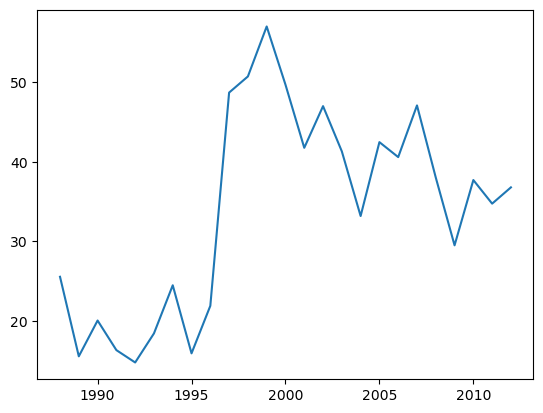

In [257]:
# Quick plot to see AQI trend
plt.plot(year_mean)

In [258]:
# Export AQI estimates to csv
year_mean.to_csv('year_mean.csv')